## Defining the Model to use

In [1]:
import os
import json
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "langgraph-Blog-Generator"

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langsmith import traceable

# model = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm=ChatGroq(model="qwen-2.5-32b")

## Defining the tools

#### Arxiv

In [2]:
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

@traceable
def arxiv_search(query):
    """
        Search for the top 3 results according to the user query using ArxivAPIWrapper.
        The information returned is a list with the top 3 related articles with at least the following information:
        Title
        Published
        Authors
        Summary
        PDF_url
    """

    arxiv = ArxivAPIWrapper(
        top_k_results = 3,
        ARXIV_MAX_QUERY_LENGTH = 300,
        load_all_available_meta = True,
        doc_content_chars_max = 5900
    )

    # Run Query and Get Results
    query = "GAN's"
    results = arxiv.load(query)

    # for article in results:
    #     print(f"Title: {article.metadata.get('Title', 'N/A')}")
    #     print(f"Published: {article.metadata.get('Published', 'N/A')}")
    #     print(f"Authors: {article.metadata.get('Authors', 'N/A')}\n")
    #     print(f"Summary: {article.metadata.get('Summary', 'N/A')[:250]}\n")
    #     print(f"PDF url: {article.metadata.get('entry_id', 'N/A')}\n")
    return results


#### Wikipedia

In [4]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

## Binding the tools

In [5]:
tools=[wiki,arxiv_search]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

## Define the Initial State

In [6]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [7]:
# System message
sys_msg = SystemMessage(content=
                        """You are a helpful assistant tasked with creating a blog.
                        Your first commitment is:
                        1. From the user's question, first use the arxiv tool to search for the top 3 articles.

                        2. Give the user the option to use wikipedia in case they want to research a term in the summaries.

                        3. Wait for user's feedback

                        4. If rejected try again from point 1.

                        5. If accepted create a blog with the articles information.
                     
                        """)
                        # If you made a reasearh in step 1, use that information to create the blog entry.


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Defining the graph

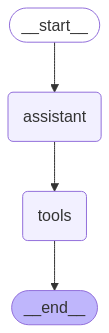

In [8]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

## Define the node
builder.add_edge(START,"assistant")
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge("assistant","tools")
builder.add_edge("tools",END)


scienceBlogCreator=builder.compile()

# Show
display(Image(scienceBlogCreator.get_graph().draw_mermaid_png()))

## Using the Agent

In [9]:
messages = [HumanMessage(content="What are GAN's?")]
messages = scienceBlogCreator.invoke({"messages":messages})

In [10]:
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

What are GAN's?
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (call_1v3m)
 Call ID: call_1v3m
  Args:
    query: GANs
================================= Tool Message =================================
Name: arxiv_search

[Document(metadata={'Published': '2021-11-26', 'Title': 'Generative Adversarial Networks and Adversarial Autoencoders: Tutorial and Survey', 'Authors': 'Benyamin Ghojogh, Ali Ghodsi, Fakhri Karray, Mark Crowley', 'Summary': 'This is a tutorial and survey paper on Generative Adversarial Network (GAN),\nadversarial autoencoders, and their variants. We start with explaining\nadversarial learning and the vanilla GAN. Then, we explain the conditional GAN\nand DCGAN. The mode collapse problem is introduced and various methods,\nincluding minibatch GAN, unrolled GAN, BourGAN, mixture GAN, D2GAN, and\nWasserstein GAN, are introduced for 